In [1]:
import scanpy.api as sc
import numpy as np
import pandas as pd
from scanpy.tools import rna_velocity
import loompy
import matplotlib.pyplot as pl
from anndata import AnnData
import seaborn as sns
from scipy.sparse import csr_matrix
import networkx as nx

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, transparent=True)
sc.logging.print_versions()

scanpy==1.1+7.g10519ea anndata==0.6.4+6.gd9727ca numpy==1.13.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Muscle

In [2]:
adata = sc.read('./write/planaria_pp_extended_loom.h5ad')

In [3]:
muscle_clusters = ['muscle body', 'muscle pharynx', 'muscle progenitors']
subset_muscle = adata.obs['clusters'].isin(muscle_clusters)
adata = adata[subset_muscle]

In [4]:
delta_embedding = np.load('./write/vlm_delta_embedding_muscle.npy')
adata.obsm['Delta_tsne'] = delta_embedding                                                                                                                                                          

We call the following ones with `legend_loc='on data export'` ones with default legend.

exporting label positions to ./write/pos.csv


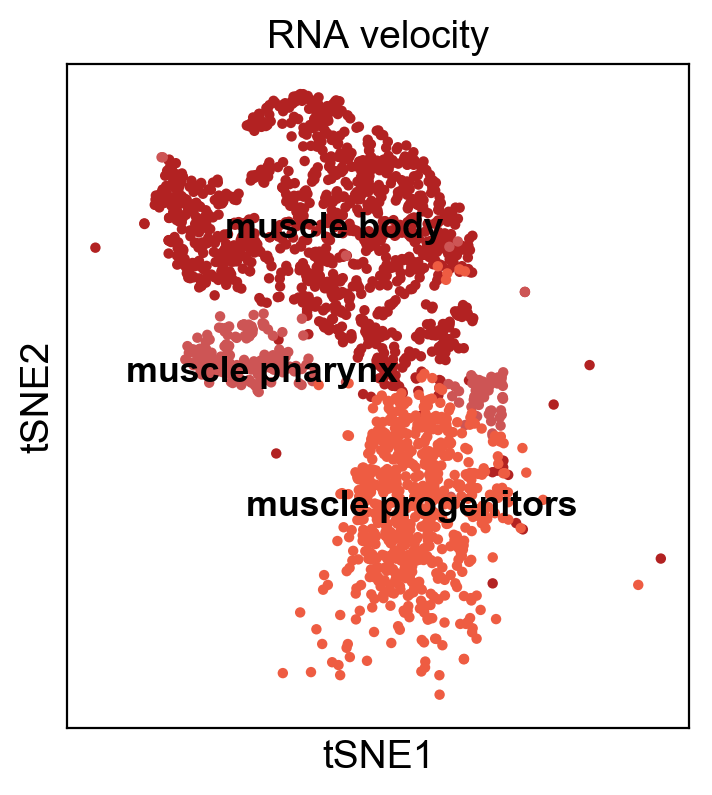

In [5]:
adata_copy = adata[np.logical_and(adata.obsm['X_tsne'][:, 0] > -20, adata.obsm['X_tsne'][:, 0] < 10)]
adata_copy = adata[np.logical_and(adata.obsm['X_tsne'][:, 1] > 15, adata.obsm['X_tsne'][:, 1] < 60)]
sc.pl.tsne(adata_copy, color='clusters', title='RNA velocity', legend_loc='on data export')

Rename the exported positions.

In [6]:
!mv ./write/pos.csv ./write/pos_muscle.csv

saving figure to file ./figures/tsne_muscle.pdf


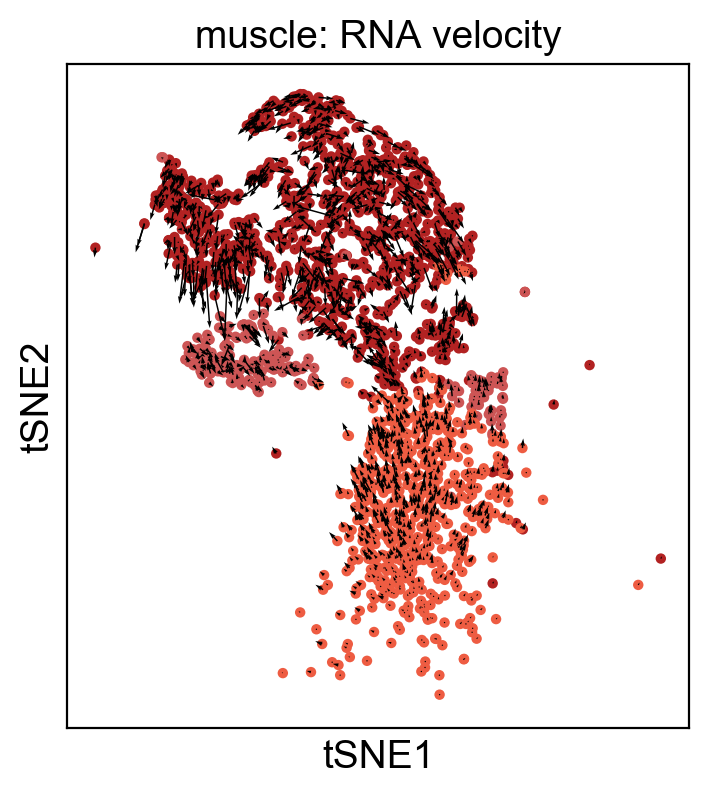

In [7]:
sc.pl.tsne(adata_copy, color='clusters', title='muscle: RNA velocity', legend_loc='none', arrows=True, save='_muscle')

Only consider transitions greater 0.01.

In [8]:
trans = np.load('./write/vlm_transition_prob_muscle.npy')
trans[trans < 0.01] = 0
trans = csr_matrix(trans)
trans

<2143x2143 sparse matrix of type '<class 'numpy.float64'>'
	with 8293 stored elements in Compressed Sparse Row format>

In [9]:
adata.uns['velocyto_transitions'] = trans

In [10]:
sc.tl.paga(adata, groups='clusters')

running partition-based graph abstraction (PAGA)
    finished (0:00:00.11) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


In [11]:
sc.tl.paga(adata, groups='clusters', use_rna_velocity=True)

running partition-based graph abstraction (PAGA)
    finished (0:00:00.25) --> added
    'paga/transitions_connectivities', connectivities adjacency (adata.uns)
    'paga/transitions_ttest', t-test on transitions (adata.uns)


In [12]:
pos = np.loadtxt('./write/pos_muscle.csv', delimiter=',')

--> added 'pos', the PAGA positions (adata.uns['paga'])


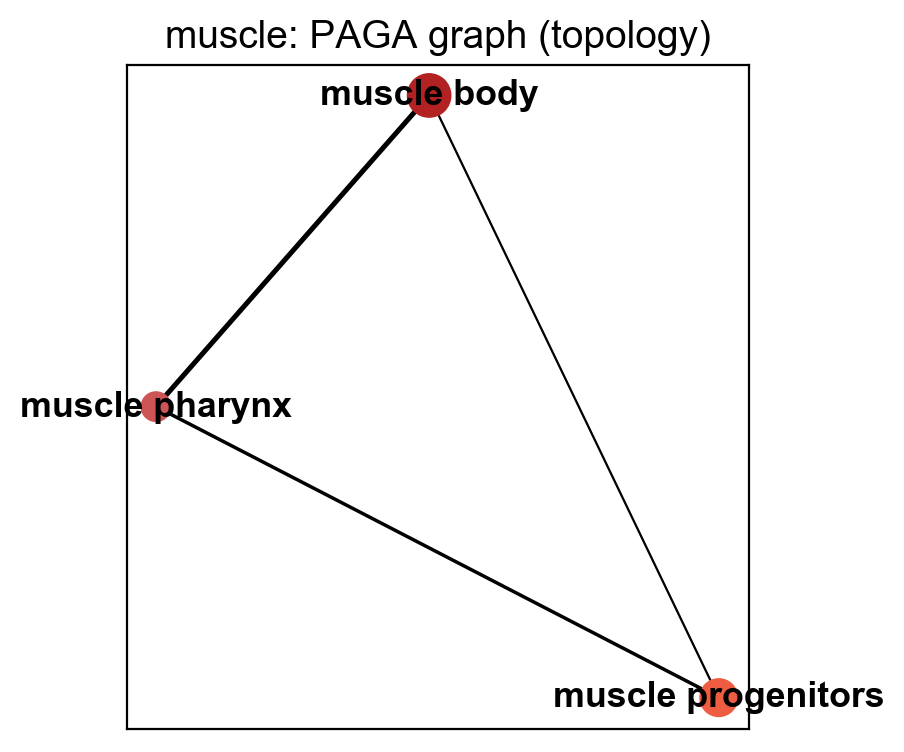

In [13]:
sc.pl.paga(adata, title='muscle: PAGA graph (topology)', pos=pos)

--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_muscle_rna_velocity.pdf


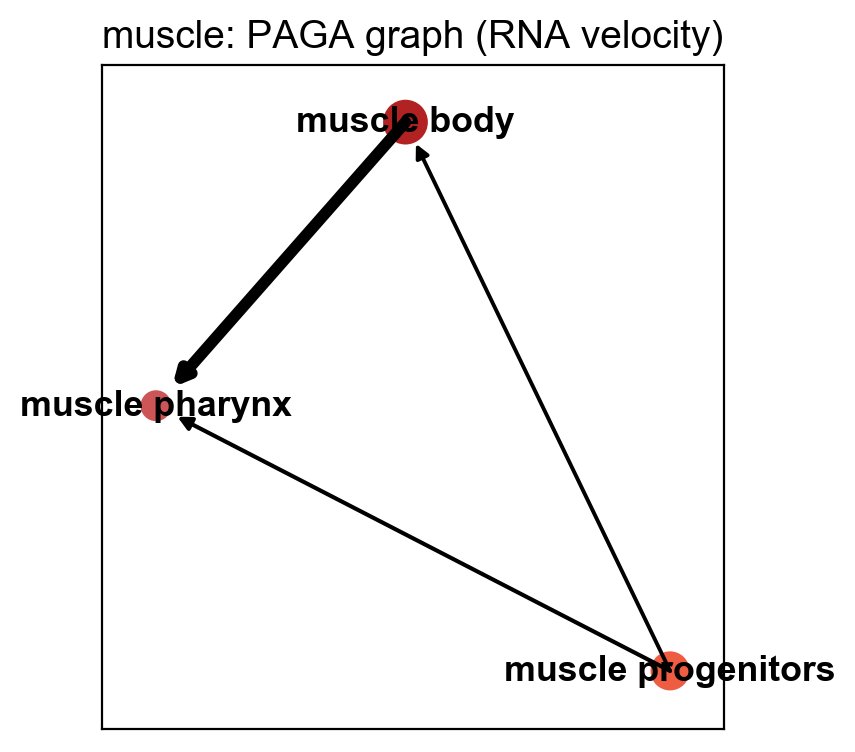

In [14]:
sc.pl.paga(adata, edge_width_scale=0.1, pos=pos, transitions='transitions_confidence',
           title='muscle: PAGA graph (RNA velocity)', save='_muscle_rna_velocity')

## Epidermis

In [15]:
adata = sc.read('./write/planaria_pp_extended_epidermis_loom.h5ad')

In [16]:
delta_embedding = np.load('./write/vlm_delta_embedding_epidermis.npy')
adata.obsm['Delta_umap'] = delta_embedding  

Reorder so that the legend is nice.

In [17]:
epidermal_clusters = [
    'epidermal neoblasts',
    'early epidermal progenitors',
    'late epidermal progenitors 1',
    'late epidermal progenitors 2', 'epidermis']
adata.obs['clusters'].cat.reorder_categories(epidermal_clusters, inplace=True)
adata.uns['clusters_colors'] = np.array(adata.uns['clusters_colors'])[[1, 0, 3, 4, 2]]

exporting label positions to ./write/pos.csv


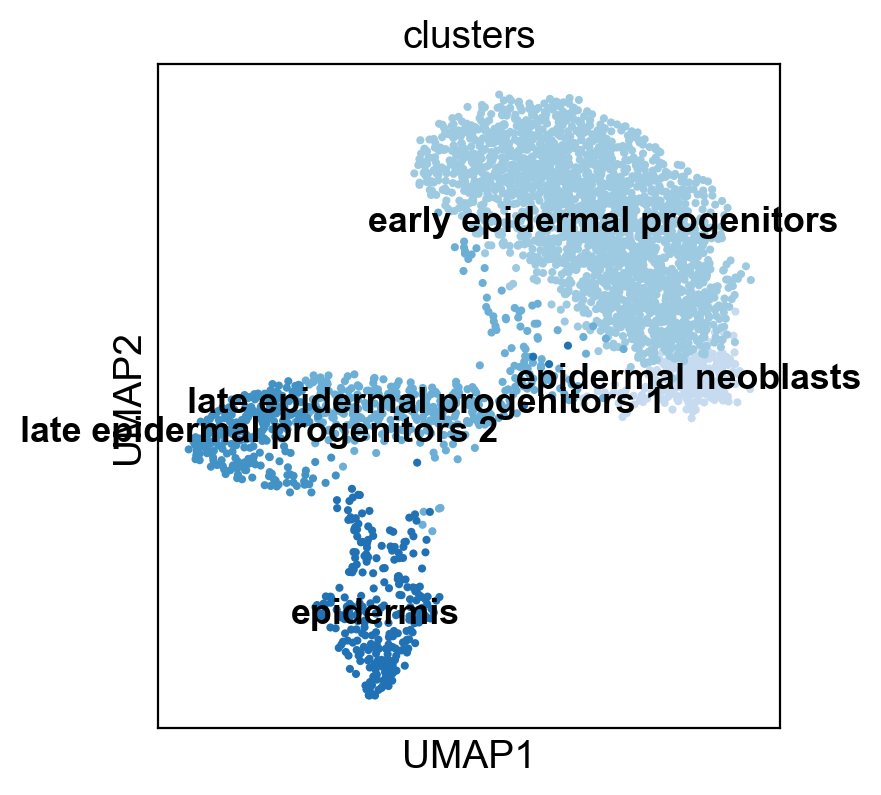

In [18]:
sc.pl.umap(adata, color='clusters', legend_loc='on data export')

In [19]:
!mv ./write/pos.csv ./write/pos_epidermis.csv

saving figure to file ./figures/umap_epidermis.pdf


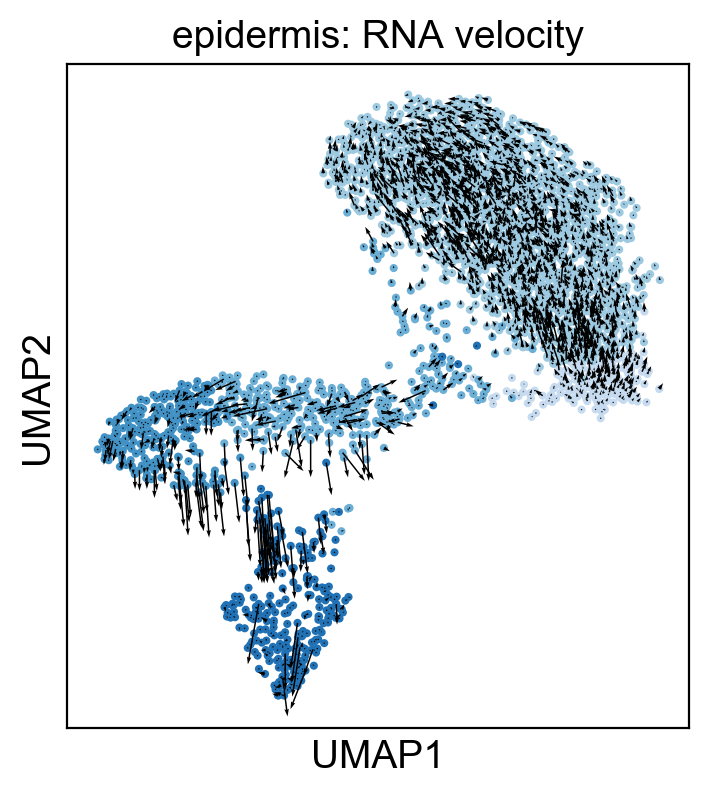

In [28]:
sc.pl.umap(adata, color='clusters', title='epidermis: RNA velocity', legend_loc='none', arrows=True, save='_epidermis')

Load transition probabilities, only consider those greater 0.01.

In [21]:
trans = np.load('./write/vlm_transition_prob_epidermis.npy')
trans[trans < 0.01] = 0
trans = csr_matrix(trans)
trans

<3514x3514 sparse matrix of type '<class 'numpy.float64'>'
	with 8363 stored elements in Compressed Sparse Row format>

In [22]:
adata.uns['velocyto_transitions'] = trans

In [23]:
sc.tl.paga(adata, groups='clusters')

running partition-based graph abstraction (PAGA)
    finished (0:00:00.20) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


In [24]:
sc.tl.paga(adata, groups='clusters', use_rna_velocity=True)

running partition-based graph abstraction (PAGA)
    finished (0:00:00.47) --> added
    'paga/transitions_connectivities', connectivities adjacency (adata.uns)
    'paga/transitions_ttest', t-test on transitions (adata.uns)


This looks a little bit different as we filtered out some cells, hence instead of 0.01, we set 0.009.

In [25]:
pos = np.loadtxt('./write/pos_epidermis.csv', delimiter=',')

--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_epidermis_connectivity.pdf


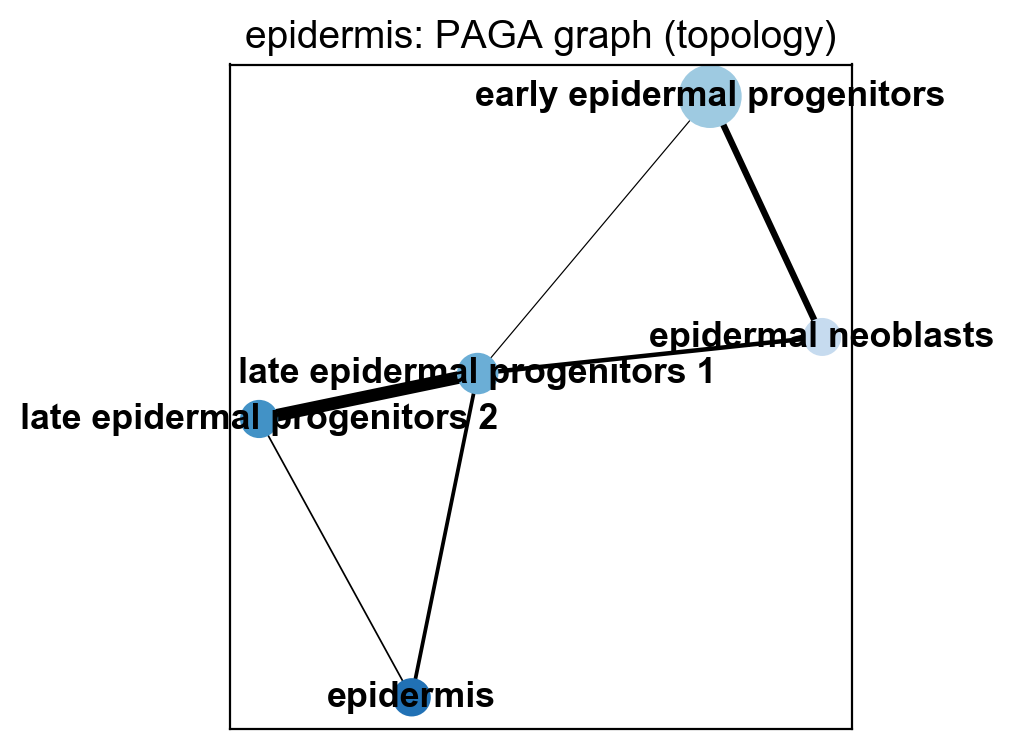

In [26]:
sc.pl.paga(adata, threshold=0.009, pos=pos, title='epidermis: PAGA graph (topology)', edge_width_scale=1, save='_epidermis_connectivity')

saving figure to file ./figures/paga_epidermis_transitions.pdf


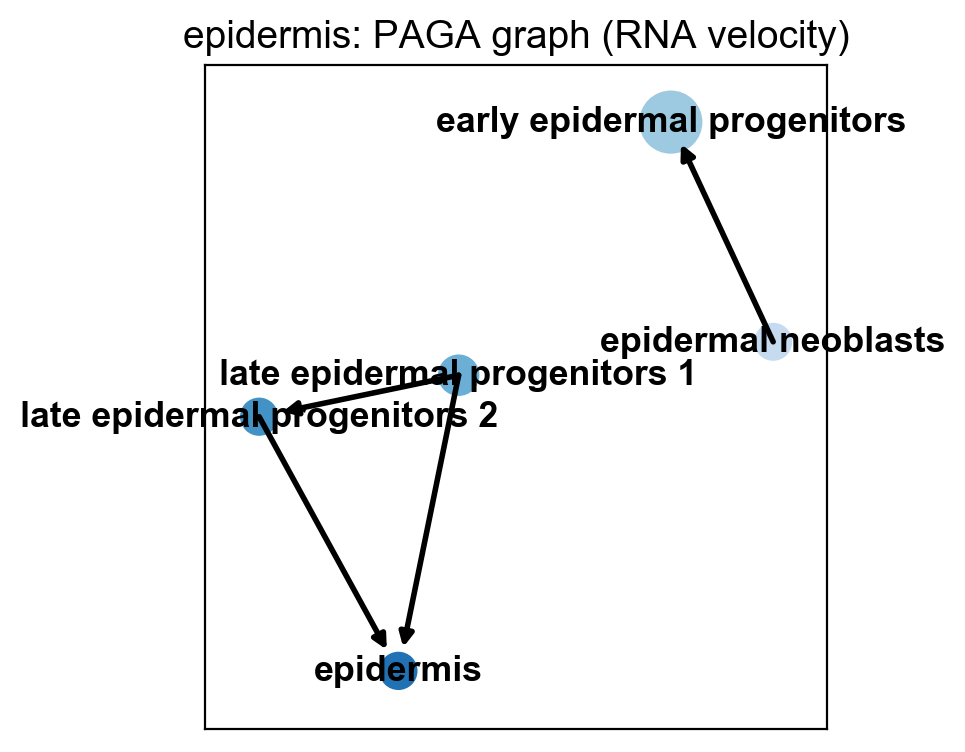

In [27]:
sc.pl.paga(adata, threshold_arrows=0.004, pos=adata.uns['paga']['pos'], add_pos=False,
           title='epidermis: PAGA graph (RNA velocity)', max_edge_width=2, transitions='transitions_confidence', save='_epidermis_transitions')